In [78]:
%autosave 60
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload
from pathlib import Path
import datetime


class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        temp = file[entry_string]["instrument"]["scm"]["T_sample"].nxvalue
        metadata_region_list["T_sample"] = temp
        ###Add temperature values here
        ### Add angle of the beam here => 
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

class XMCD_data_analysis(Nexus_handling):
    def __init__(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []
        #self.temperature
   

    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx

        if len(XMCD_spectra_Set) != 1:
            for ﬁle_number in XMCD_spectra_Set: 
                print(file_number)
                data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
                self.spectra.append(data_set)
                self.energy = self.spectra[0]["x"]
        else:
            print(XMCD_spectra_Set)
            data_set = self.open_single_spectra(XMCD_spectra_Set[0], directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
    
            self.energy = self.spectra[0]["x"]
#######################################################################################
    ### Plotting functions
    
    def plot_spectra(self,XAS_file_Set,i, bounds = None, normalisation = None):
        #Plots a single XAS spectra out of a set 
        #XAS_file_set : a set of XAS scan numbers
        #i : the indice of which scan you want to plot
        Energy,Idio = XMCD.spectra[i]["x"],XMCD.spectra[i]["y"]
        if bounds is not None:
            plt.xlim(bounds[0])
            plt.ylim(bounds[1])

        if normalisation is not None:
            value = np.mean(Idio[:normalisation])
            plotting_y = Idio - value
            plotting_y = plotting_y / np.max(plotting_y) 
        else:
            plotting_y = Idio


        plt.plot(Energy,plotting_y,label = XAS_file_Set[i])
        plt.title(("XAS ",sensor,XAS_file_set[i],self.spectra[i]["meta"]["polarisation"]))
        plt.legend()
        plt.xlabel("Energy(eV)")
        plt.ylabel("idio")   

    def Dichroism(self,XMCD_ﬁle_Set, normalisation = None,scaling_factor=1, avg = "Before", on_top = False):
        #Takes in a series of XAS spectra of opposing polarisations then averages all the nc and all the pc and subtracts them to give us the dichroism
        # XMCD_file_Set : list of XAS spectra, at a minimum we need one of each polarisation of light.

        fig = plt.figure(figsize=(12, 6))
        
        if on_top:
            [axXAS, axXMCD] = fig.subplots(1,2, sharey=True)  # (nrows, ncols, index)
            
        else:
            [axXAS, axXAS_pc, axXMCD] = fig.subplots(1,3, sharey=True)  # (nrows, ncols, index)
            axXAS_pc.set_title("pc")
        
        
        axXAS.set_title("nc")
        axXMCD.set_title("XMCD")
        
        nc_storage = np.zeros(len(self.energy))
        pc_storage = np.zeros(len(self.energy))
        
        B_Field = self.spectra[0]["meta"]["magnet_ﬁeld"]
        temp = self.spectra[0]["meta"]["T_sample"]
        fig.suptitle("Dichroism at " + str(np.round(B_Field,2)) +  f"T {round(temp,3)}K")
        print("B Field - ",B_Field)
        
        
        
        axXMCD.set_xlabel("energy (eV")
        axXAS.set_ylabel("idio")
        
        n,m = 0,0
        max_point = 0

        
        for i in range(0,len(XMCD_file_Set)):
            Polarisation = self.spectra[i]["meta"]["polarisation"]
            F = self.spectra[i]["y"]

            if normalisation is not None:
                value = np.mean(F[:normalisation])
                F -= value

            
            f=np.polyfit(self.energy, F, 1)

            fit=np.polyval(f,self.energy)
            mx = np.max((F-fit)+0.1)
            if mx > max_point:
                max_point = mx
            if Polarisation == "nc":
                F = F * scaling_factor
                nc_storage += F
                n += 1
                axXAS.plot(self.energy,F, label = f"{XMCD_file_Set[i]} nc" )
                axXAS.legend()

            elif Polarisation == "pc":
                pc_storage = pc_storage + F
                m = m + 1
                if on_top:
                    axXAS.plot(self.energy,F,label = f"{XMCD_file_Set[i]}  pc" )
                else:
                    axXAS_pc.plot(self.energy,F,label = XMCD_file_Set[i] )
                    axXAS_pc.legend()

        if avg == "Before":
            nc_storage = nc_storage/n
            pc_storage = pc_storage/m
            dichroism = abs(pc_storage) - abs(nc_storage)

            max_dichroism = np.max(dichroism)
            percentage = 100*max_dichroism/max_point
            print(f"Max Di - {max_dichroism}, Max Signal - {max_point}")
        
        axXMCD.plot(self.energy,dichroism,label = f"XMCD - {np.round(percentage,3)}%")
        axXMCD.legend()

        
        axXMCD.axhline(y = 0, color = 'b', linestyle = 'dashed') 
        axXAS.axhline(y = 0, color = 'b', linestyle = 'dashed') 
        if not on_top:
            axXAS_pc.axhline(y = 0, color = 'b', linestyle = 'dashed') 
            
        return self.energy,dichroism                    

def prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor):
    XMCD = XMCD_data_analysis()
    XMCD.load_spectra(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)
    return XMCD

def get_values(file):
    
    nexus = nxload(file)
    TEY_A=nexus.entry.instrument.hyst2.detector1_A.nxvalue 
    TEY_B=nexus.entry.instrument.hyst2.detector1_B.nxvalue 
    I_0_A = nexus.entry.instrument.hyst2.detector2_A.nxvalue 
    I_0_B = nexus.entry.instrument.hyst2.detector2_B.nxvalue 
    
    return [TEY_A, TEY_B, I_0_A, I_0_B]



def Hysteresis(files, offset=[0,0]):
    if len(files) != 4:
        print("Wrong number of files")
        return 0
    values = {}
    
    for file in files:
        data = get_values("FILES/HOPG1/Hysteresis/" + file)
        for i, datum in enumerate(data):
            values[f"{file} {i}"] = datum # 0 = TeyA, 1 = TEYB, 2 = I0A, 3 = I0B

    nexus = nxload("FILES/HOPG1/Hysteresis/" + files[0])
    B_field = nexus.entry.instrument.hyst2.value.nxvalue

    
    norm_dict = {}
    numerator_6_8 = (((values[f"{files[0]} 0"] / values[f"{files[0]} 2"]) - (values[f"{files[0]} 1"] / values[f"{files[0]} 3"])) - ((values[f"{files[2]} 0"] / values[f"{files[2]} 2"]) - (values[f"{files[2]} 1"] / values[f"{files[2]} 3"])))
    denominator_6_8 = 0.5* (((values[f"{files[0]} 0"] / values[f"{files[0]} 2"]) - (values[f"{files[0]} 1"] / values[f"{files[0]} 3"])) + ((values[f"{files[2]} 0"] / values[f"{files[2]} 2"]) - (values[f"{files[2]} 1"] / values[f"{files[2]} 3"])))
    plotting_1 = numerator_6_8/denominator_6_8

    numerator_7_9 = -(((values[f"{files[1]} 0"] / values[f"{files[1]} 2"]) - (values[f"{files[1]} 1"] / values[f"{files[1]} 3"])) - ((values[f"{files[3]} 0"] / values[f"{files[3]} 2"]) - (values[f"{files[3]} 1"] / values[f"{files[3]} 3"])))
    denominator_7_9 = 0.5* (((values[f"{files[1]} 0"] / values[f"{files[1]} 2"]) - (values[f"{files[1]} 1"] / values[f"{files[1]} 3"])) + ((values[f"{files[3]} 0"] / values[f"{files[3]} 2"]) - (values[f"{files[3]} 1"] / values[f"{files[3]} 3"])))
    plotting_2 = numerator_7_9/denominator_7_9

    plt.figure(1)
    plt.plot(B_field, numerator_6_8, "s-" ,label = "PC") # just (A - B) - (C-D)
    plt.plot(B_field, numerator_7_9,"d-" ,label = "nC")
    plt.axhline(y=0)
    plt.axvline(x=0)
    plt.legend()
    
    plt.figure(2)
    plt.plot(B_field, plotting_1+offset[0],"s-", label = "PC_norm") # (A - B) - (C-D) / (0.5*(A - B) + (C-D))
    plt.plot(B_field, plotting_2+offset[1],"d-", label = "nC_norm")
    plt.legend()
    plt.axhline(y=0)
    plt.axvline(x=0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def method1(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, temp, label = XMCD

    hyst_point = max(XMCD)-min(XMCD)
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield, temp

def method2(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, temp, label = XMCD

    avg_bkgd = np.mean(XMCD[:10])
    nearest_point, idx = find_nearest(pc_Fenergy, 576.8)
    hyst_point = XMCD[idx] - avg_bkgd
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield, temp

def method3(XMCD):
    XMCD,pc_Bfield, nc_Bfield,pc_Fenergy, temp, label = XMCD

    xxxx, idx_max = find_nearest(pc_Fenergy, 576.8)
    xxxx, idx_min = find_nearest(pc_Fenergy, 578)
    max_point = XMCD[idx_max]
    min_point = XMCD[idx_min]

    hyst_point = max_point - min_point
    Bfield = (pc_Bfield + nc_Bfield)/2
    
    return hyst_point, Bfield, temp

def get_remenance(hyst, B):

    idx_list = []
    
    for i, x in enumerate(B):
        if abs(x) == 0.0:
            idx_list.append(i)
    
    i_1 = idx_list[0]
    i_2 = idx_list[1]
    
    rem_1 = hyst[i_1]
    rem_2 = hyst[i_2]


    print(f"Rem 1 ({B[i_1]} ): {rem_1}, Rem 2 ({B[i_2]} ): {rem_2}, half_point: {0.5*(abs(rem_1) + abs(rem_2))}")

    
    remenance = 0.5*(abs(rem_1) + abs(rem_2)) 

    return remenance
    
    

def manual_hyst(data_dir,Yield = "TEY",normalisation=None,bounds =None, plot_xmcd=True, Label = False, scaling = None, scale_io=False):

    files = [f.name for f in data_dir.iterdir() if f.is_file()]
    files.sort()
    import os
    cwd = os.getcwd()
    print(cwd)
    mid = int(len(files)/2)
    
    pc_files = files[:mid]
    nc_files = files[mid:]
    # print("PC: ", pc_files)
    # print("NC: ", nc_files)

    final_pc = []
    final_nc = []
    
    for i, file in enumerate(files):
        nexus = nxload(str(data_dir)+ "/" + file)
        B_field = nexus.entry.instrument.scm.field_z.nxvalue
        if Yield == "TEY":
            TEY=nexus.entry.instrument.fesData.C1.nxvalue 
        elif Yield == "TFY":
            TEY=nexus.entry.instrument.fesData.C5.nxvalue     
        I0=nexus.entry.instrument.fesData.C2.nxvalue
        Fenergy = nexus.entry.instrument.fastEnergy.value.nxvalue
        polar = nexus.entry.instrument.id.polarisation.nxvalue
        temp = nexus.entry.instrument.scm.T_sample
        if scale_io:
            if polar == "pc":
                norm_TEY = TEY/(I0+700)
            elif polar == "nc":
                norm_TEY = TEY/(I0+550)
        else:
            norm_TEY = TEY/I0

        if normalisation is not None:
            value = np.mean(norm_TEY[:normalisation])
            TEY_final = norm_TEY - value
        else:
            TEY_final = norm_TEY

        data = [TEY_final, B_field, Fenergy,temp, file]
        
        if polar == "pc":
            final_pc.append(data)
            # print(data[3], i)
        elif polar == "nc":
            final_nc.append(data)
            # print("nc",data[3], i)

    
    XMCDs = []
    
    for i, data in enumerate(final_pc):
        pc_TEY, pc_Bfield, pc_Fenergy,pc_temp, pc_file = data
        nc_TEY,nc_Bfield,nc_Fenergy, nc_temp,nc_file = final_nc[i]
        if scaling is not None:
            nc_TEY *= scaling
        XMCD =  pc_TEY - nc_TEY
        # print(pc_file, nc_file)
        height_pc = max(pc_TEY) - min(pc_TEY)
        height_nc = max(nc_TEY) - min(nc_TEY)
        XMCD_norm = XMCD /(0.5*(height_pc +height_nc))
        label = f"{pc_file} - {nc_file} @ {pc_Bfield}/{nc_Bfield} @ {temp}K"
        # print(label)
        temp =(pc_temp + nc_temp)*0.5
        
        XMCD_data = [XMCD_norm, pc_Bfield, nc_Bfield,  pc_Fenergy,temp, label]

        percentage = 100*(max(abs(XMCD))/max((max(abs(nc_TEY)) ,max(abs(pc_TEY)))))
        
        XMCDs.append(XMCD_data)
        if plot_xmcd:
            plt.figure(i)
            
            fig, [axXAS, axXMCD] = plt.subplots(1,2, sharey=False)
            axXAS.plot(pc_Fenergy, pc_TEY, label="pc")
            axXAS.plot(nc_Fenergy, nc_TEY, label="nc")
            axXMCD.plot(pc_Fenergy, XMCD_norm, label = "Norm XMCD")
            # axXMCD.plot(pc_Fenergy, XMCD, label = "XMCD")
            axXAS.legend
            
            axXAS.axvline(x=576.8, alpha=0.25, color = "b",linestyle = 'dashed', label = "576.8")
            axXAS.axvline(x=578.0, alpha=0.25, color = "c",linestyle = 'dashed', label = "578.0")
            axXMCD.axvline(x=576.8, alpha=0.25, color = "b",linestyle = 'dashed', label = "576.8")
            axXMCD.axvline(x=578.0, alpha=0.25, color = "c",linestyle = 'dashed', label = "578.0")
            plt.title(label)
            
            plt.axhline(y = 0, color = 'b', linestyle = 'dashed', label=f"{ round(percentage,3) }% ")
            plt.legend()
    # print(len(XMCDs))
    plt.figure(len(final_pc)+2) 
    M1_hyst, M1_B = [], []
    M2_hyst, M2_B= [], []
    M3_hyst, M3_B = [], []
    temps = []
    for i, XMCD in enumerate(XMCDs):
        # hyst, B, temp = method1(XMCD)
        # M1_hyst.append(hyst)
        # M1_B.append(B)

        # hyst, B, temp = method2(XMCD)
        # M2_hyst.append(hyst)
        # M2_B.append(B)
        
        hyst, B, temp = method3(XMCD)
        M3_hyst.append(hyst)
        M3_B.append(B)
        temps.append(temp)
        if Label:
            plt.text(B,hyst, f"{i} {60-i}")
        
    co = np.arange(0,len(XMCDs),1)
    # plt.figure(31)
    # plt.scatter(M1_B, M1_hyst, c=co,cmap='winter')
    # plt.figure(32)
    # plt.scatter(M2_B, M2_hyst, c=co,cmap='winter')
    plt.scatter(M3_B, M3_hyst,marker='o' ,c=co,cmap='inferno')
    # plt.plot(M3_B, M3_hyst,linestyle="-" ,c="r")
    if bounds is not None:
        plt.xlim(bounds[0])
        plt.ylim(bounds[1])
    
    plt.axhline(y=0)
    plt.axvline(x=0)

    plt.colorbar()
    
    remenance =  get_remenance(M3_hyst, M3_B)
    return max(M3_hyst), remenance, remenance/max(M3_hyst)

    
    


print("Saved Code")
directory_path = r"FILES/"
ﬁle_preﬁx = "i06-1-"
in_bounds = [[-0.1,0.1],[-0.1,0.1]]


print("ALL GOOD HERE BOSS: ", datetime.datetime.now())


Autosaving every 60 seconds
Saved Code
ALL GOOD HERE BOSS:  2025-02-02 18:59:38.164251


C:\Users\ppxfc1\OneDrive - The University of Nottingham\Desktop\PhD\Code\PhD-Codes\Diamond_CrCl3_jan2025
Rem 1 (0.0 ): 0.10929604581735054, Rem 2 (-0.0 ): -0.06716852742074675, half_point: 0.08823228661904864


(1.0675616569569415, 0.08823228661904864, 0.08264842226588826)

<Figure size 640x480 with 0 Axes>

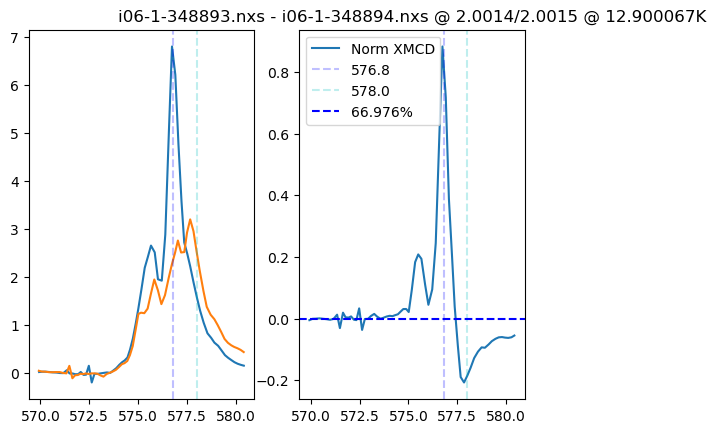

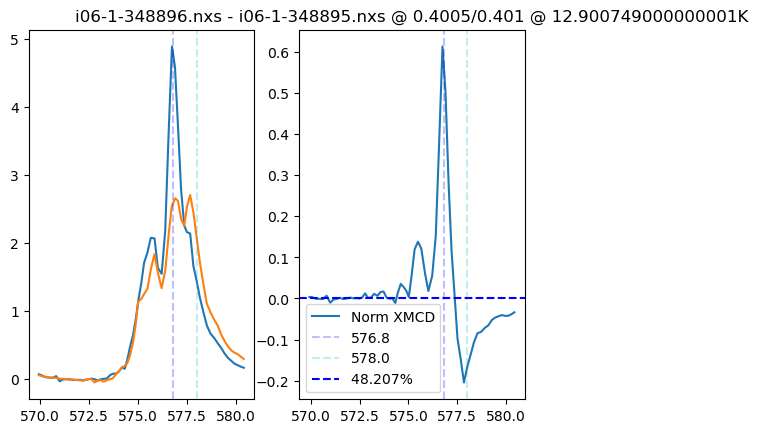

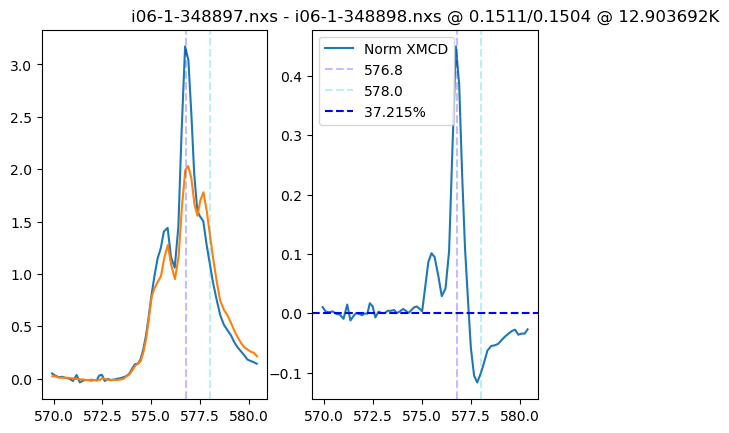

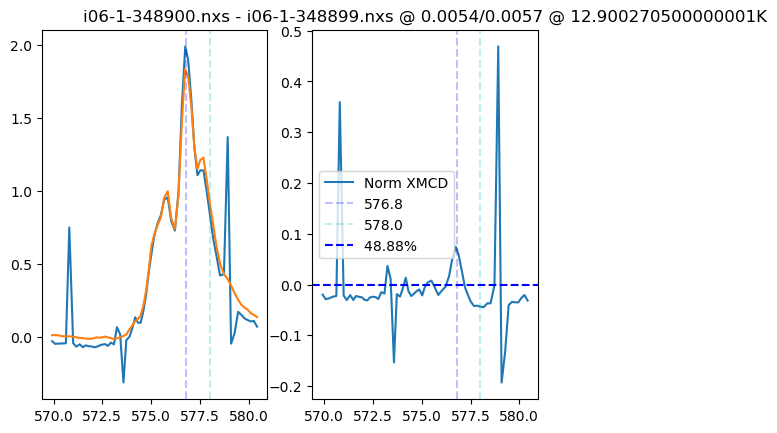

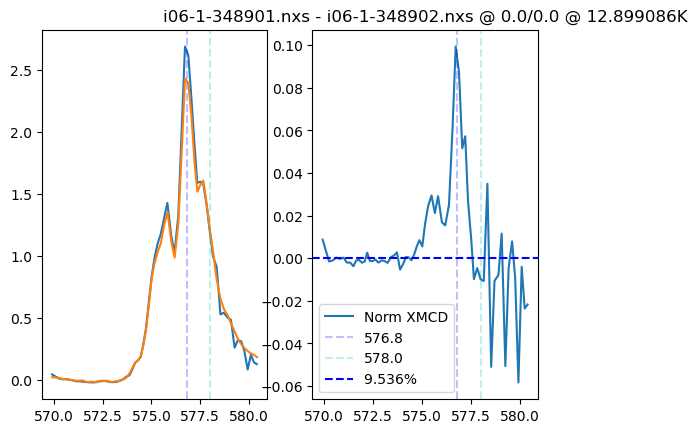

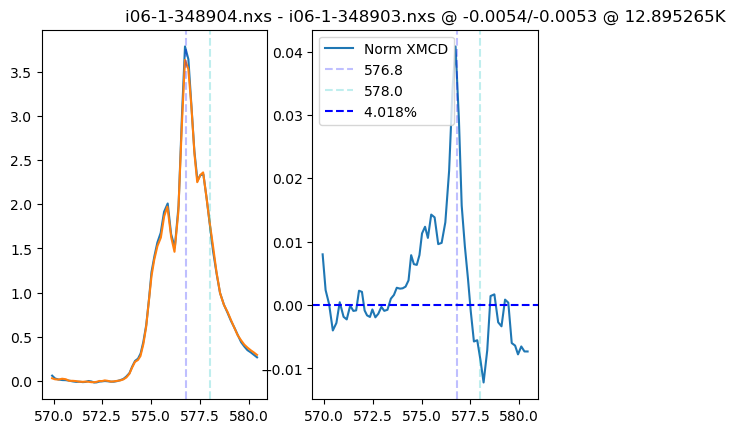

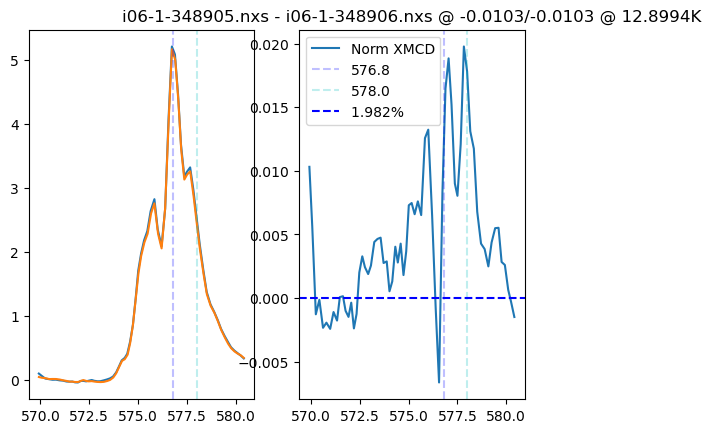

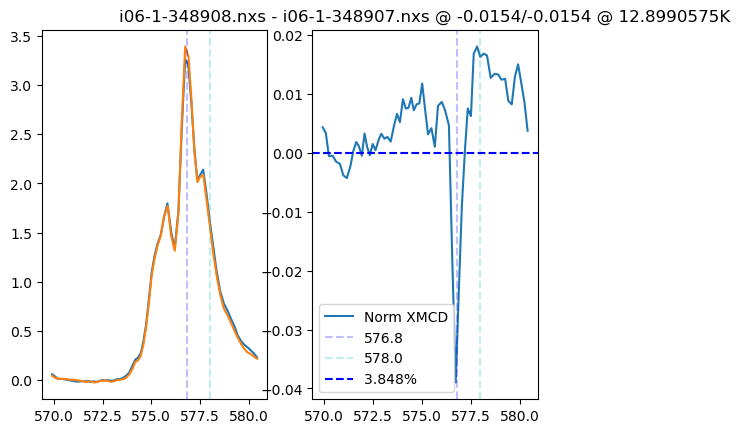

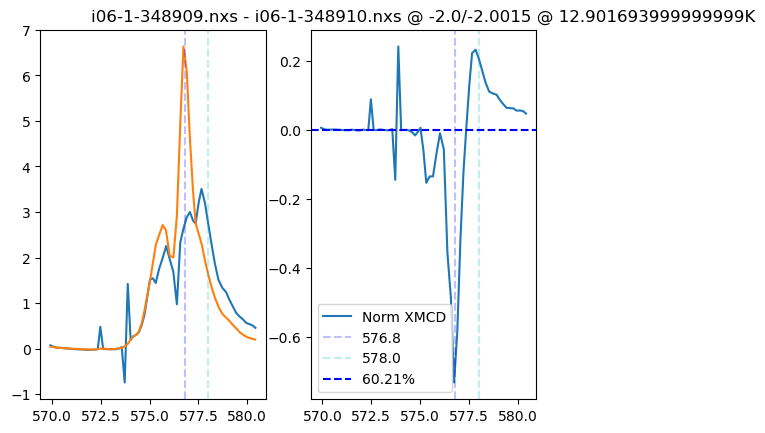

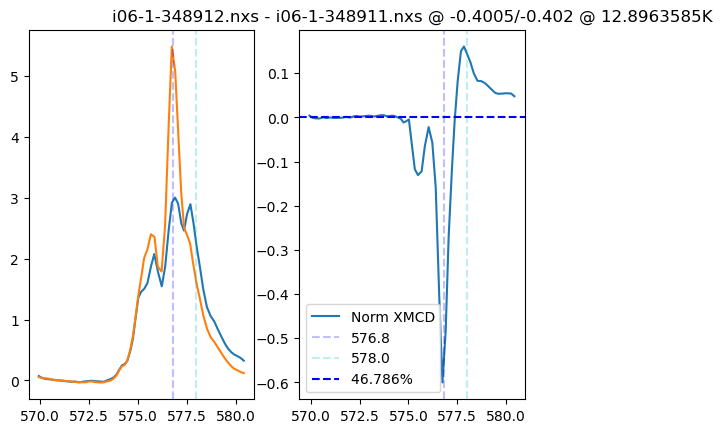

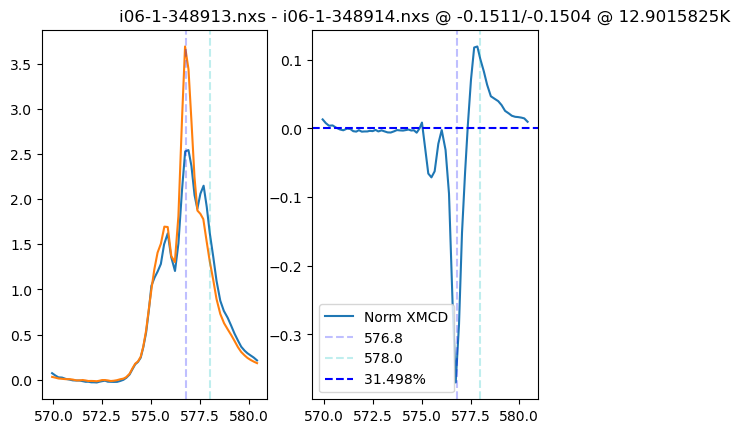

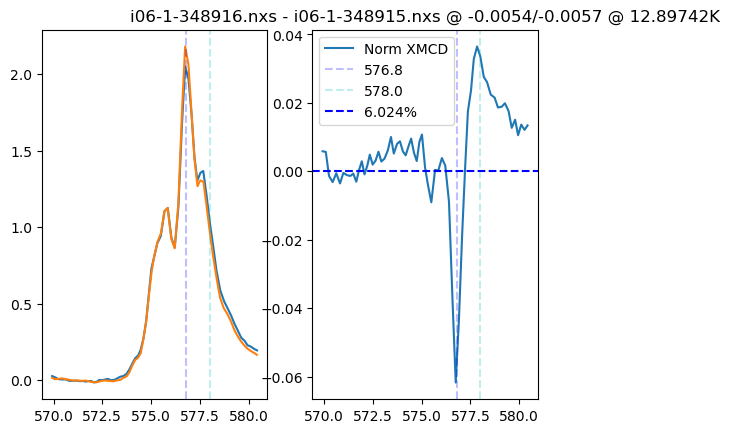

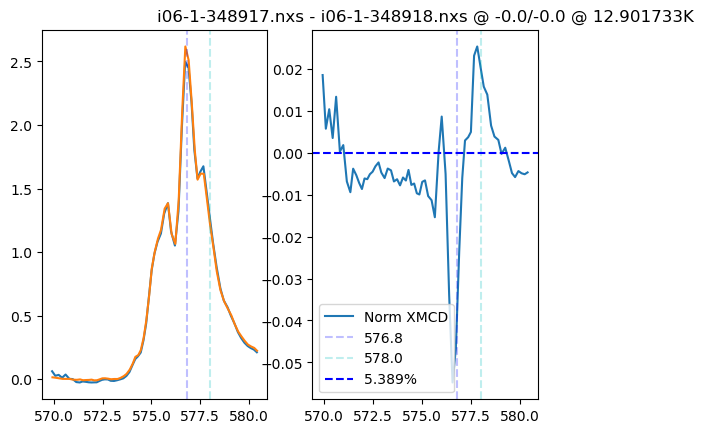

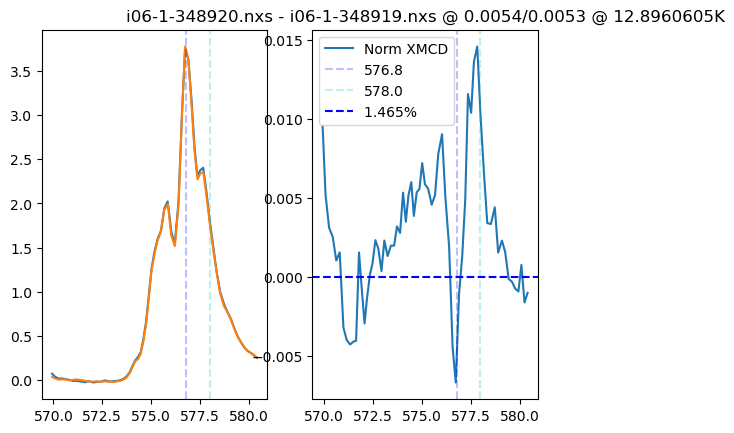

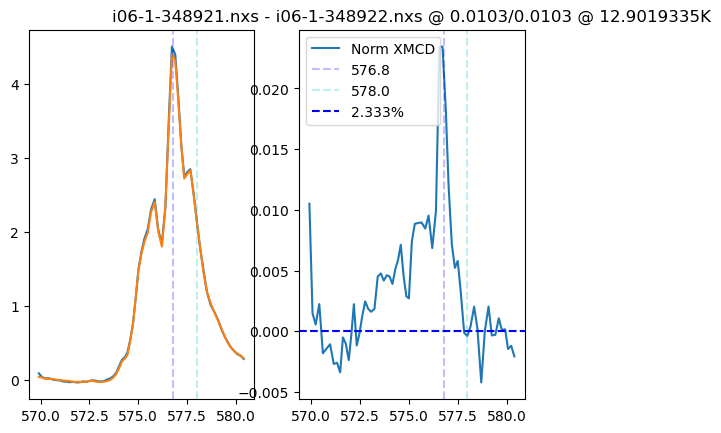

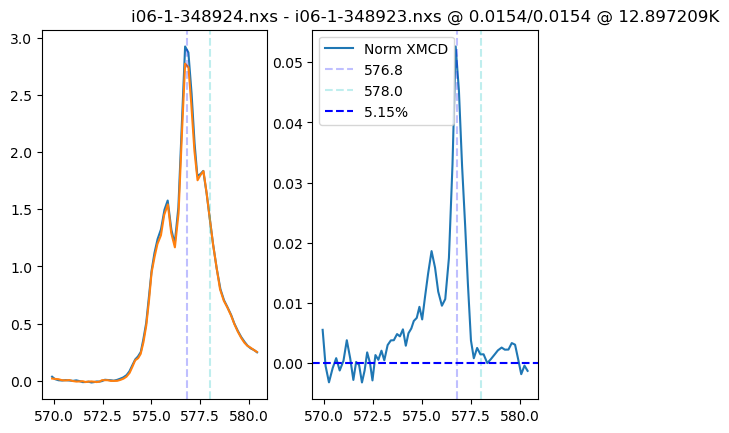

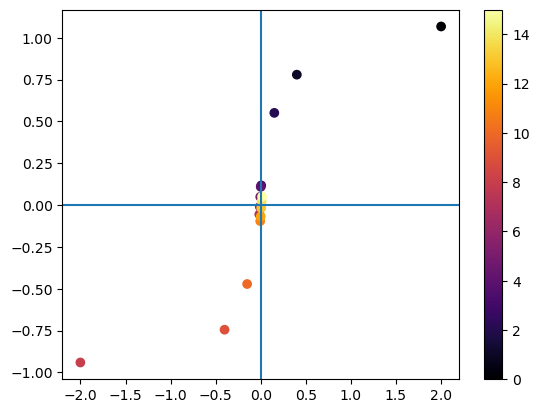

In [91]:
file_path = Path("Diamond data/FILES/BP1/Hysteresis_analysis/Hyst_12.9k/")

manual_hyst(file_path, Yield = "TEY", normalisation=15, plot_xmcd =True, bounds = None, scaling=1.08, scale_io=False)

C:\Users\ppxfc1\OneDrive - The University of Nottingham\Desktop\PhD\Code\PhD-Codes\Diamond_CrCl3_jan2025
Rem 1 (0.0 ): 0.05401630236492301, Rem 2 (-0.0 ): -0.018315162897603404, half_point: 0.03616573263126321


(0.8947286268181105, 0.03616573263126321, 0.040420895841768285)

<Figure size 640x480 with 0 Axes>

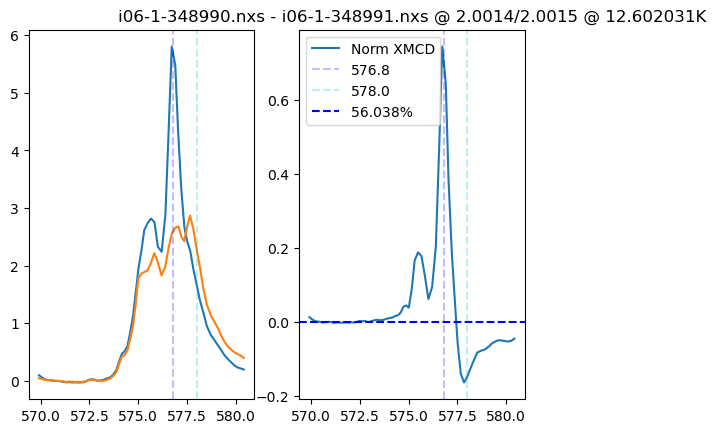

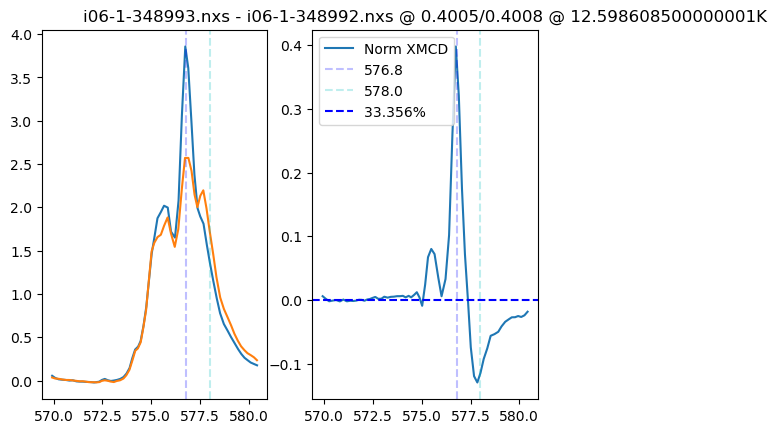

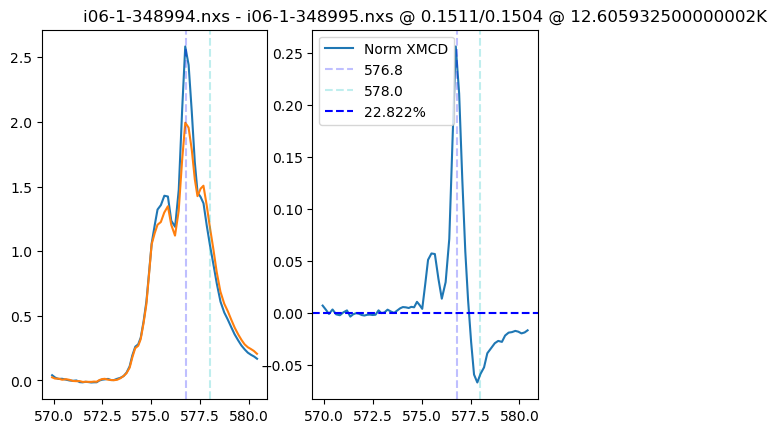

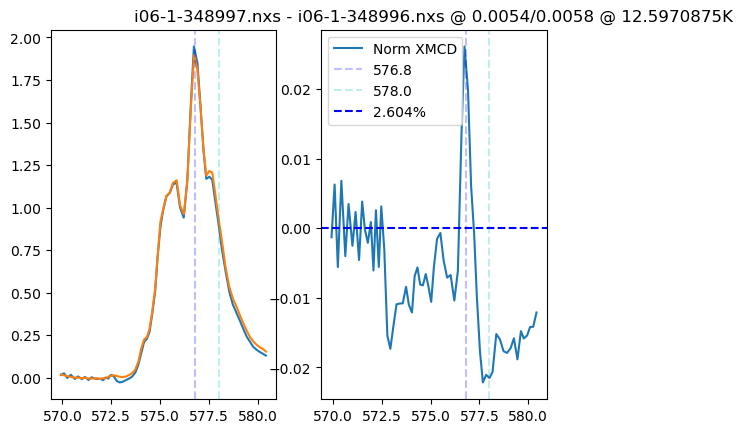

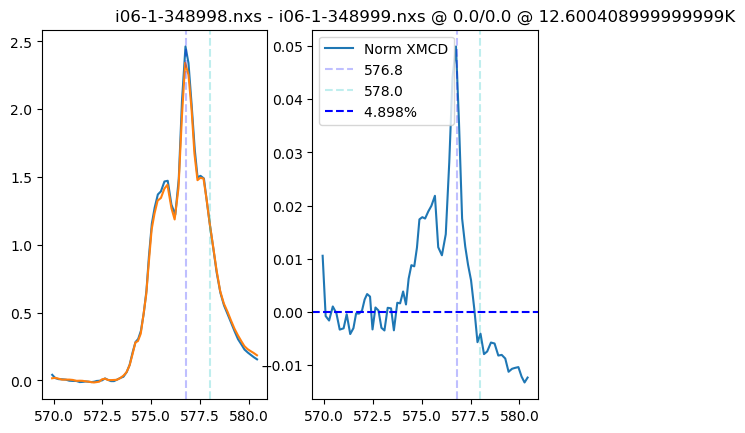

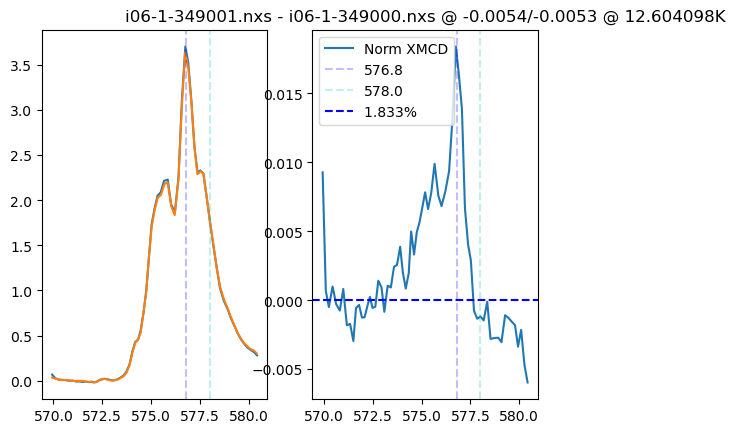

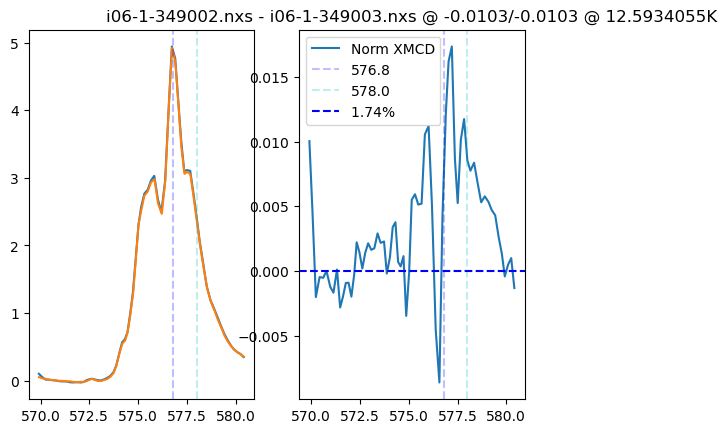

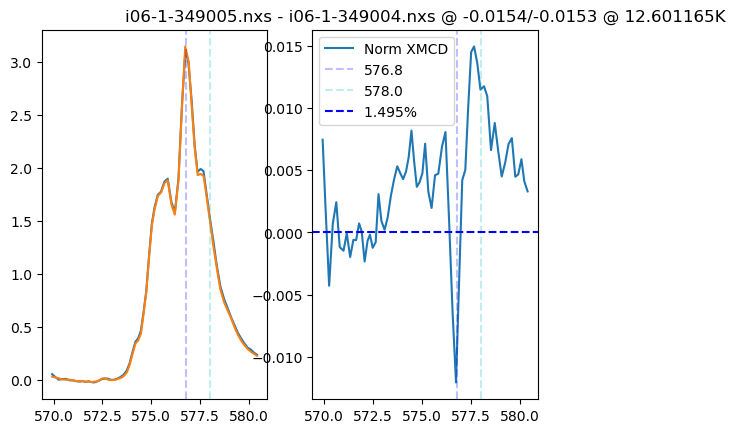

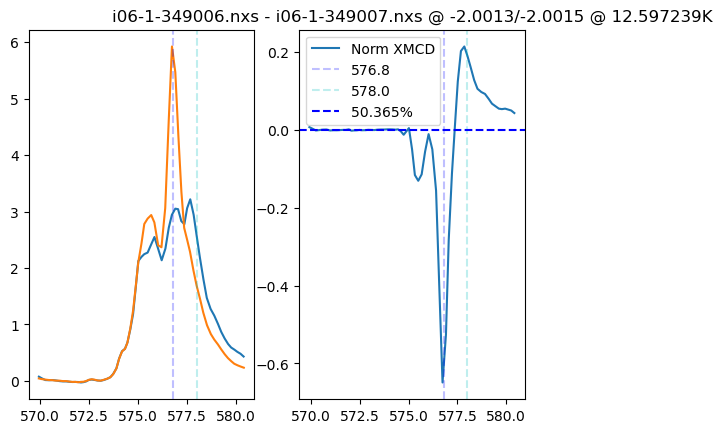

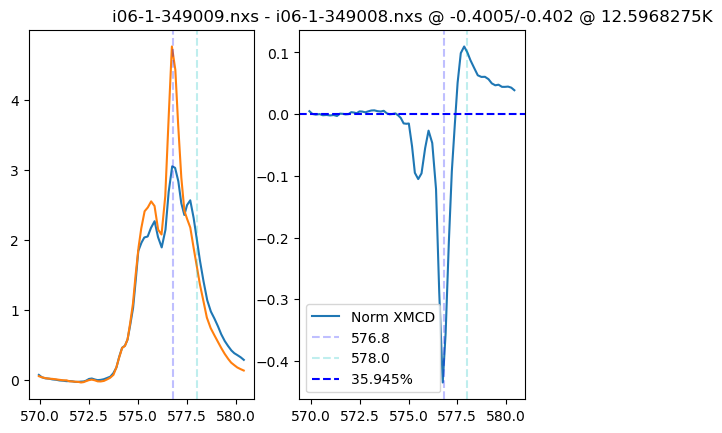

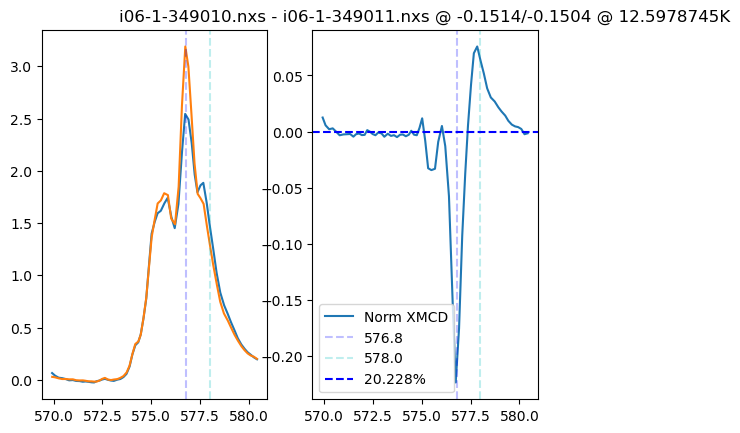

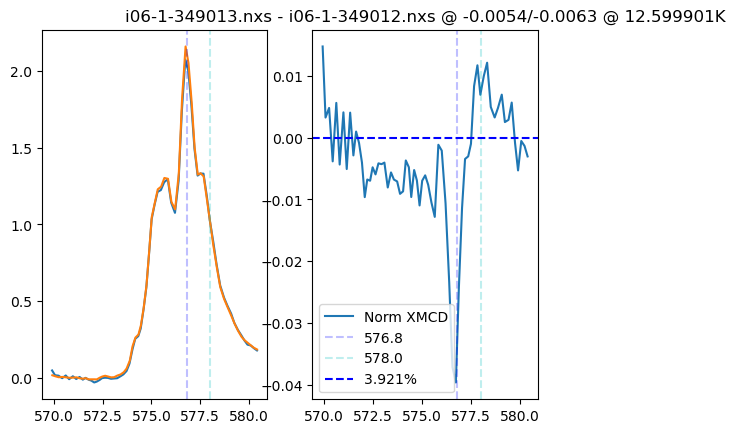

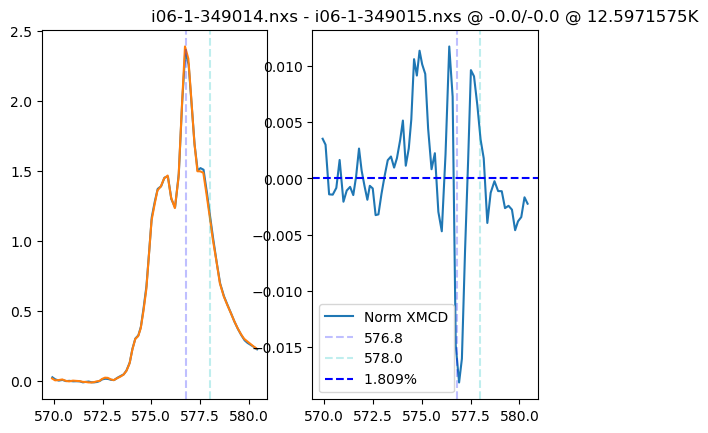

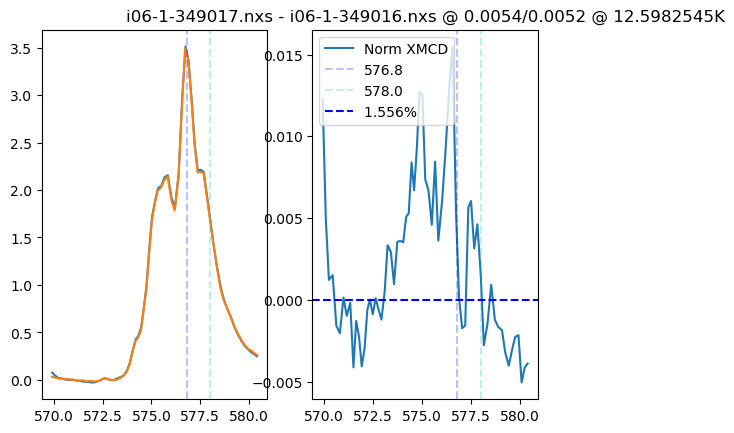

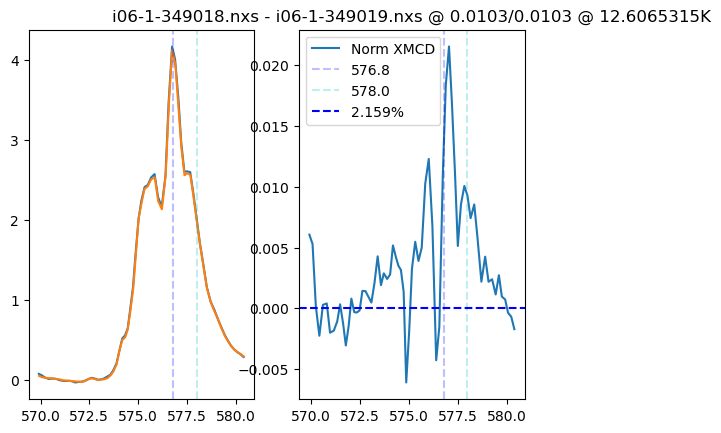

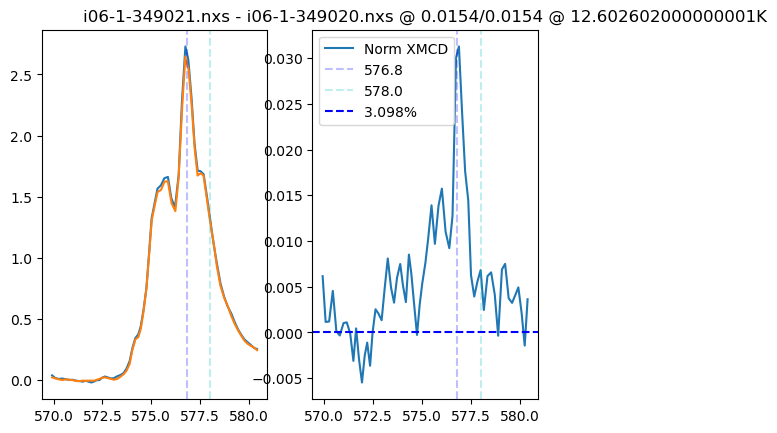

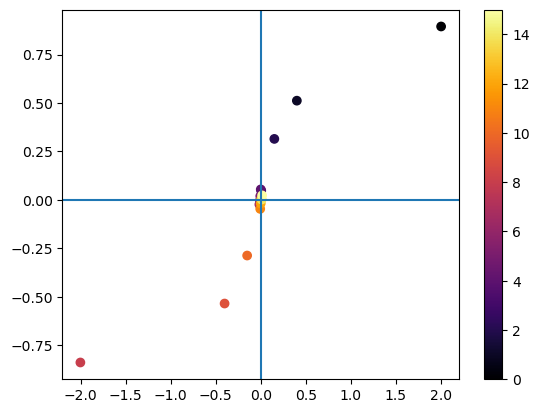

In [59]:
file_path = Path("Diamond data/FILES/BP1/Hysteresis_analysis/Hyst_12.6k_2/")

manual_hyst(file_path, Yield = "TEY", normalisation=15, plot_xmcd =True, bounds = None, scaling=1.08)

C:\Users\ppxfc1\OneDrive - The University of Nottingham\Desktop\PhD\Code\PhD-Codes\Diamond_CrCl3_jan2025
Rem 1 (0.0 ): 0.04629989283038215, Rem 2 (-0.0 ): -0.015235195797440058, half_point: 0.030767544313911103


(0.7844810478664168, 0.030767544313911103, 0.03922025190741162)

<Figure size 640x480 with 0 Axes>

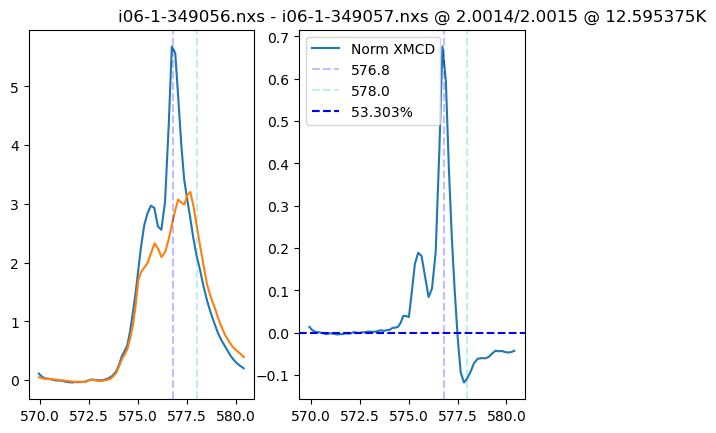

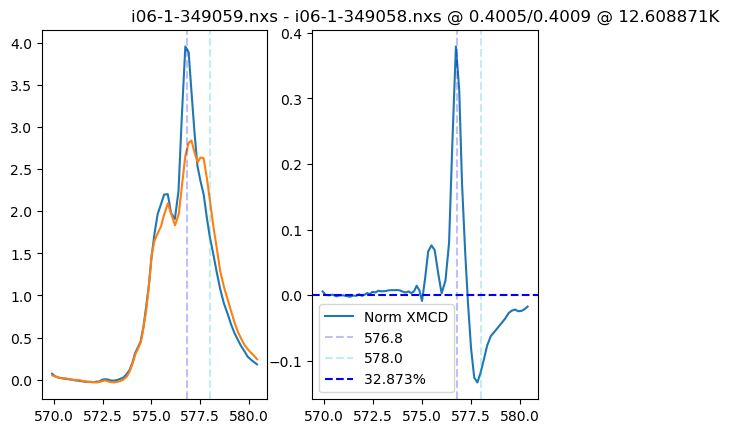

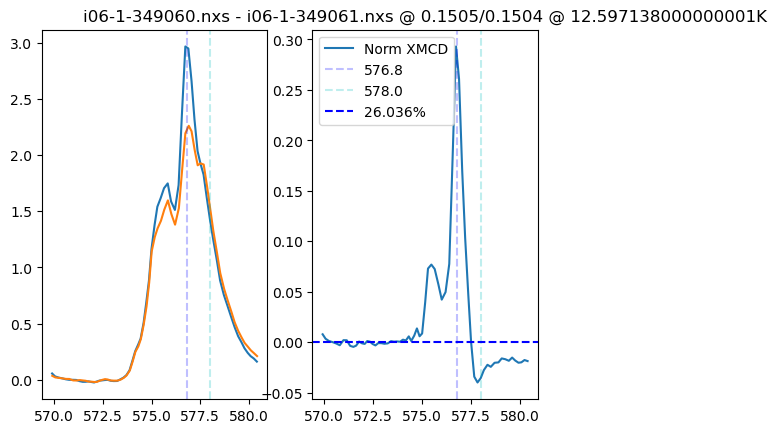

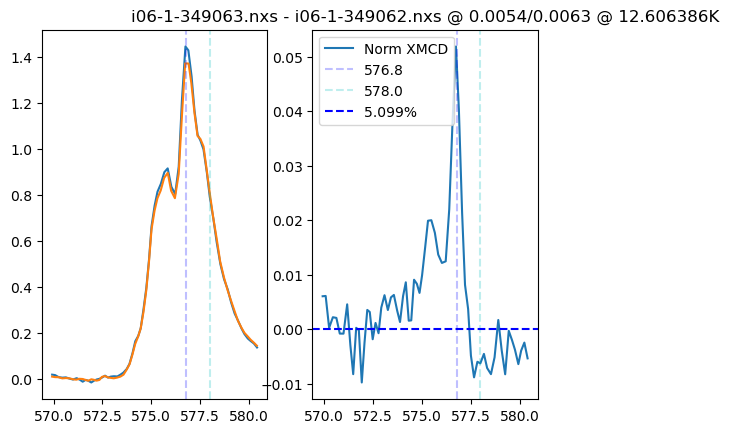

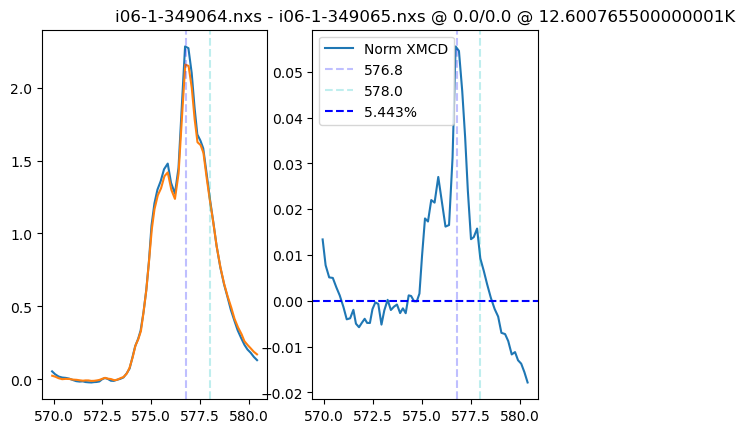

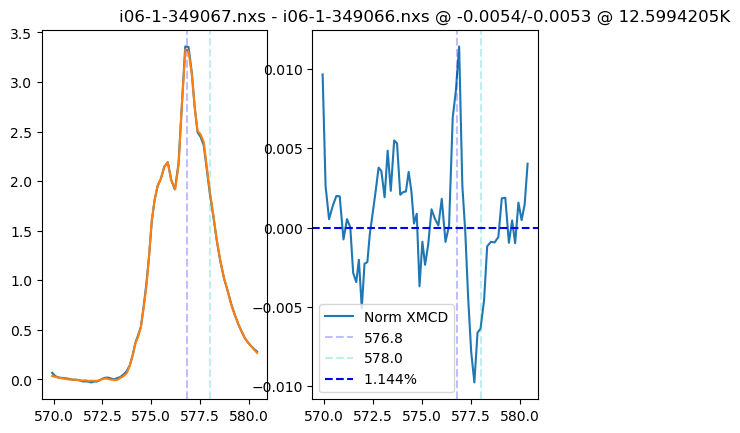

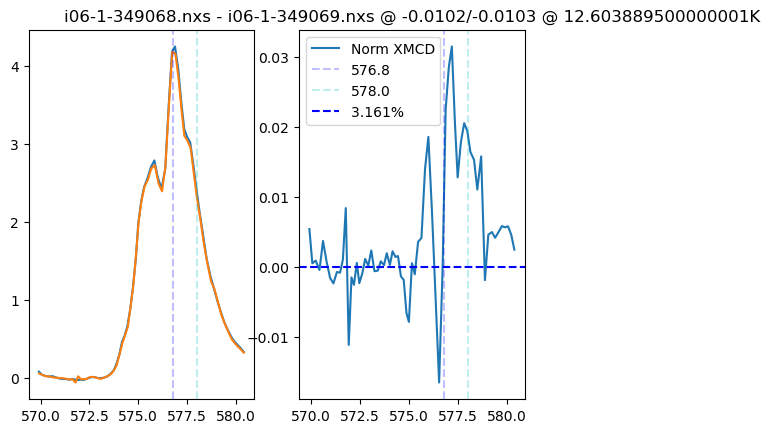

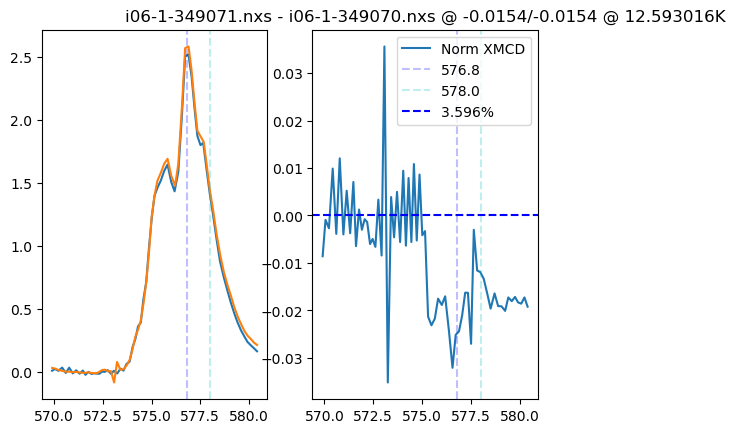

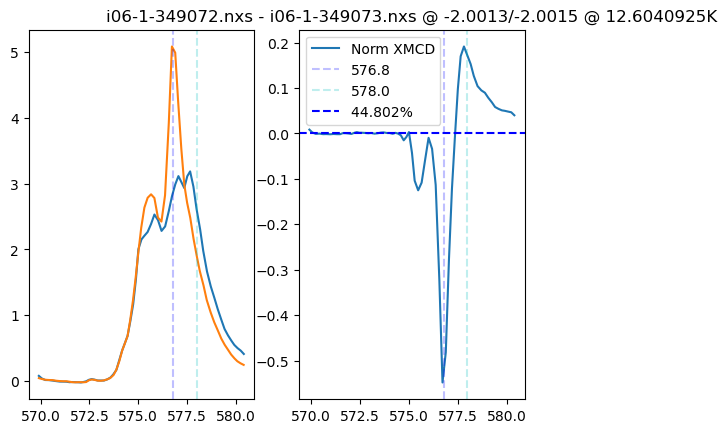

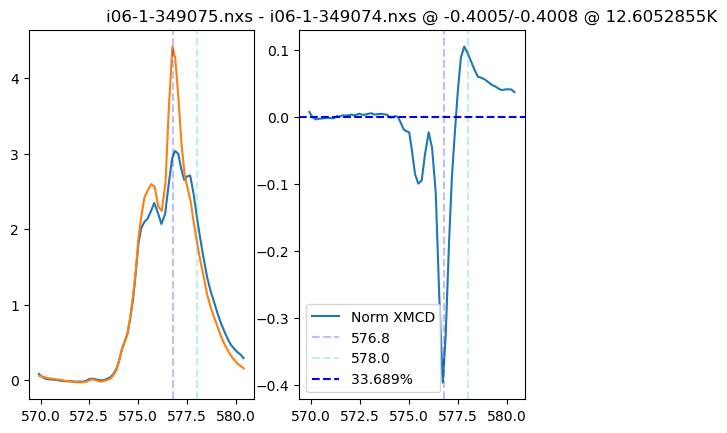

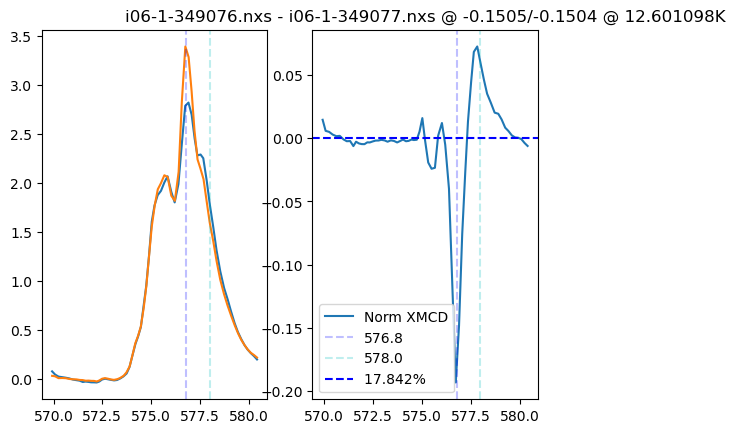

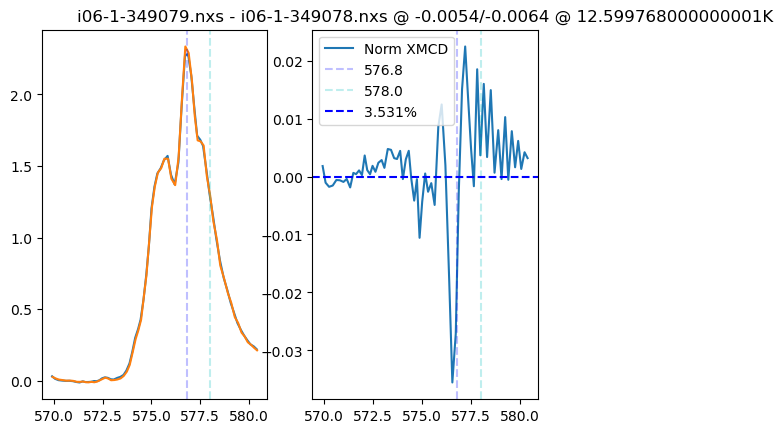

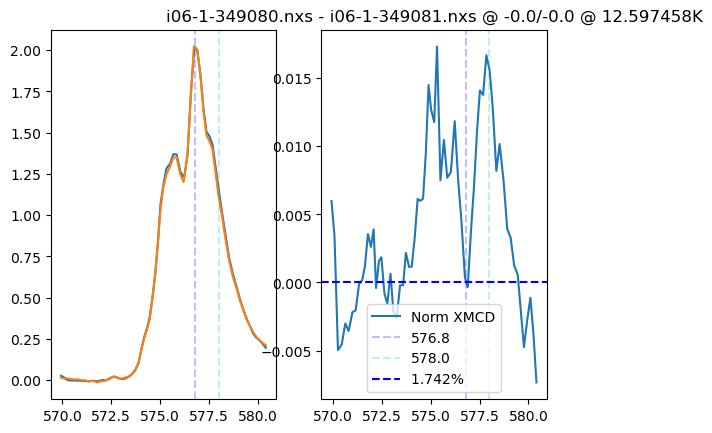

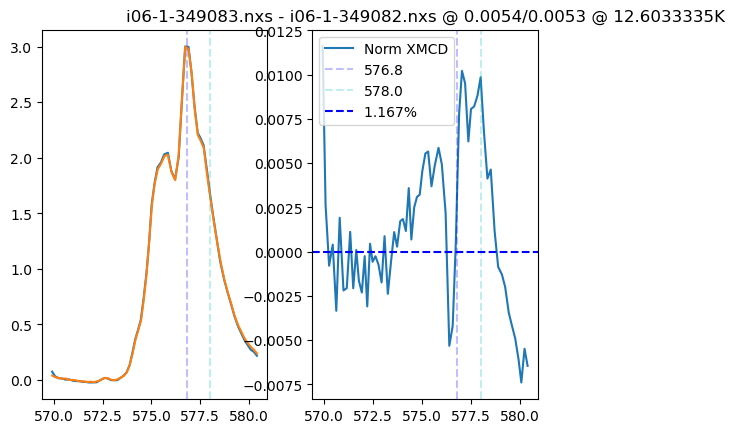

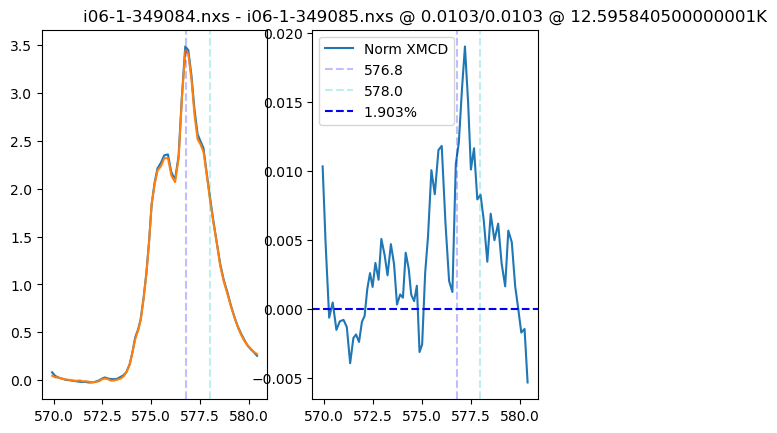

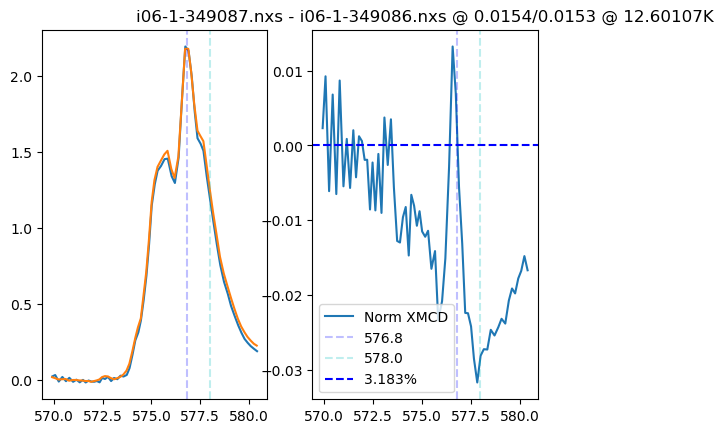

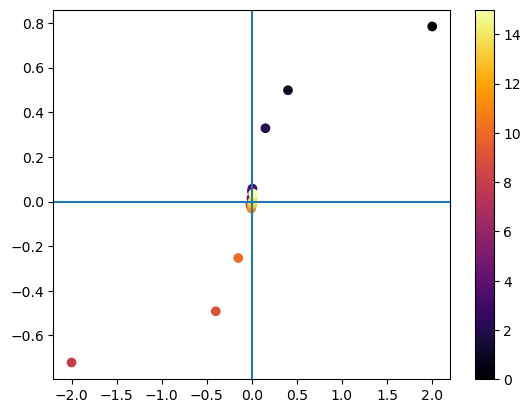

In [58]:
file_path = Path("Diamond data/FILES/BP1/Hysteresis_analysis/Hyst_12.6k_3/")

manual_hyst(file_path, Yield = "TEY", normalisation=15, plot_xmcd =True, bounds = None, scaling=1.08)